# ML 서울시 따릉이 자전거 이용 예측 경진대회

: 2017년 4월 1일부터, 5월 31일까지 시간별로 서울시 따릉이 대여수와 기상상황 데이터가 주어집니다.

: 각 날짜의 1시간 전의 기상상황을 가지고 1시간 후의 따릉이 대여수를 예측해보세요. 

In [ ]:
# 패키지 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/kubig - 머신러닝 스터디/따릉이 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/kubig - 머신러닝 스터디/따릉이 경진대회/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/kubig - 머신러닝 스터디/따릉이 경진대회/submission.csv')

In [ ]:
# 둘러보기
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


> feature 살펴보기
- id :날짜와 시간 별 id
- hour : 시간
- hour_bef_temperature : 1시간 전 기온
- hour_bef_precipation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가 오면 1 => dummy!
- hour_bef_windspeed : 1시간 전 풍속(평균)
- hour_bef_humidity : 1시간 전 습도
- hour_bef_visibility : 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- hour_bef_ozone : 1시간 전 오존
- hour_bef_pm10 : 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- hour_bef_pm2.5 : 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count : 시간에 따른 따릉이 대여 수

In [ ]:
train.shape

(1459, 11)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


- 모두 숫자형 자료 ! 
- 문자열을 숫자형으로 변환 작업 필요 x


In [ ]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [ ]:
# missing value 확인
np.sum(pd.isnull(train)).sum()

300

In [ ]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

- null 값 제거 필요

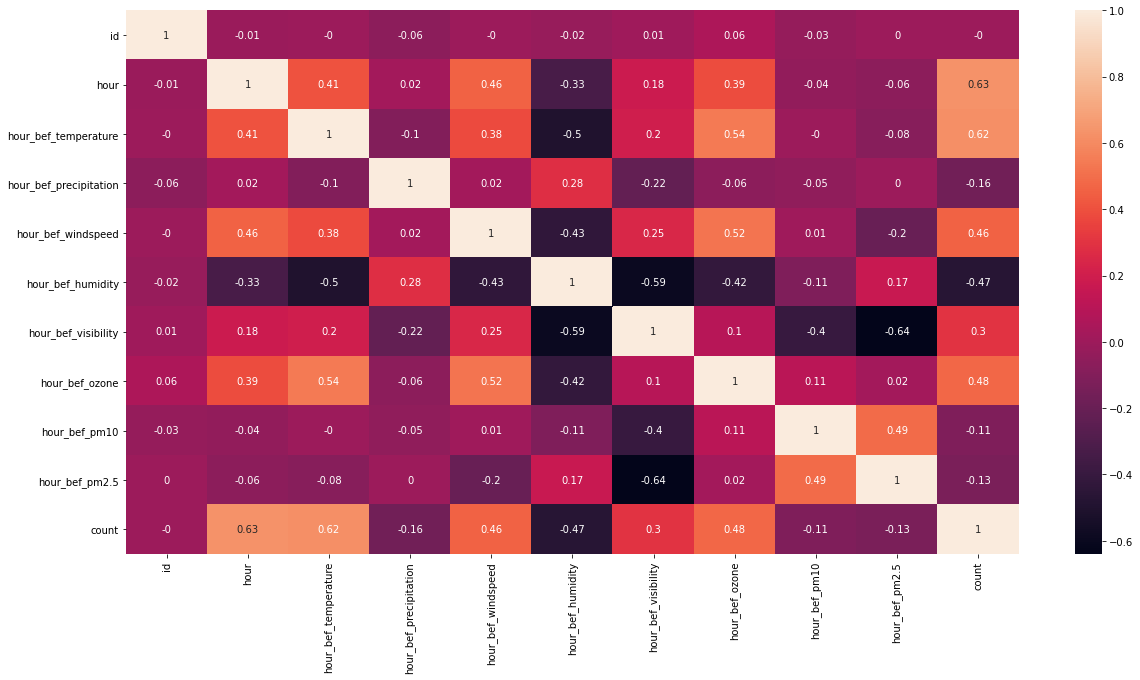

In [ ]:
# 히트맵 
# correlations with the MEDV
plt.figure(figsize=(20, 10))
correlation_matrix = train.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

# 1. 전처리

## * 결측치 제거 

- figure out why the data is missing
:  It can be a frustrating part of data science, especially if you're newer to the field and don't have a lot of experience. For dealing with missing values, you'll need to use your intution to figure out why the value is missing.

In [ ]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

Text(0.5, 1.0, 'Total Missing Value (%)')

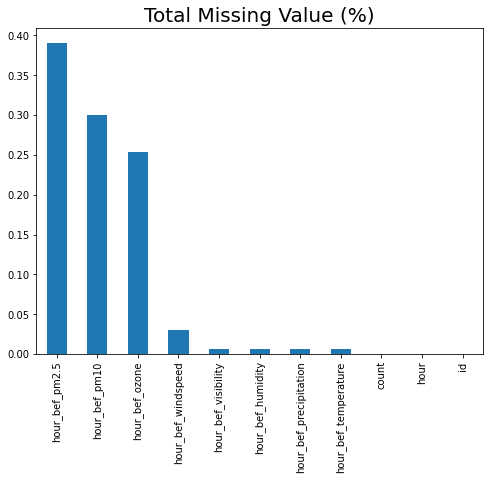

In [ ]:
total = train.isna().sum().sort_values(ascending=False)
percent = (train.isna().sum()/train.isna().sum().sum()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

- 결측값 비중 순서

Text(0.5, 1.0, 'Correlation with Missing Values')

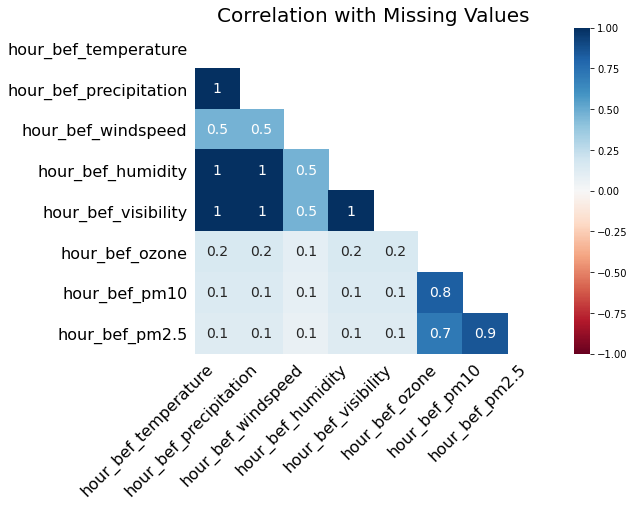

In [ ]:
# 결측치간 correlation
import missingno as msno
missingdata_df = train.columns[train.isnull().any()].tolist()
msno.heatmap(train[missingdata_df], figsize=(8,6))
plt.title("Correlation with Missing Values", fontsize = 20)

- missing vlaue의 유형을 MCAR/MAR/MNAR로 구분
- 그래서 매트릭스 그려서 어디서 결측값 발생하고 있는지 봐보겠음 ! 

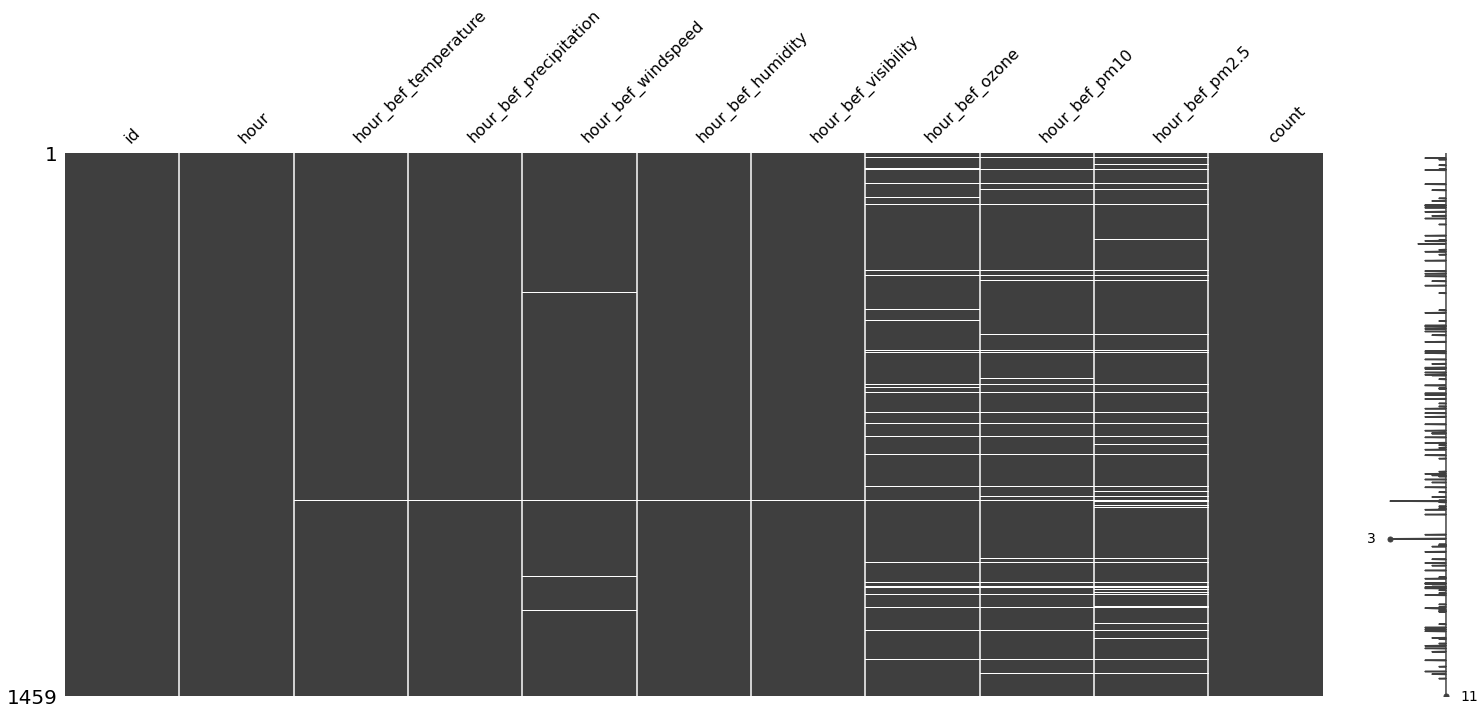

In [ ]:
msno.matrix(train)

## [1] hour_bef_temperature/ hour_bef_precipitation/ hour_bef_humidity/ hour_bef_visibility:결측값 2개 => DROP

In [ ]:
train[train['hour_bef_temperature'].isna()]  # temperature 결측값 위치

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


- 이 경우 id와 hour, 그리고 count를 제외한 모든 피처들에서 동시에 누락되었으니, 굳이 imputation 필요 없다고 판단 -> drop

In [ ]:
# temperature drop
train.dropna(subset=['hour_bef_temperature'], inplace=True)

In [ ]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          7
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             74
hour_bef_pm10              88
hour_bef_pm2.5            115
count                       0
dtype: int64

## [2]  hour_bef_windspeed  -  결측값 7개 => DROP

In [ ]:
train[train['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,33,13,22.6,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.1,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.0,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.3,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.5,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
1138,1717,12,21.4,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.0,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


In [ ]:
corr_matrix = train.corr().abs()
corr_matrix["hour_bef_windspeed"].sort_values(ascending=False)

hour_bef_windspeed        1.000000
hour_bef_ozone            0.520526
hour                      0.462797
count                     0.459906
hour_bef_humidity         0.433012
hour_bef_temperature      0.375618
hour_bef_visibility       0.252092
hour_bef_pm2.5            0.199113
hour_bef_precipitation    0.022746
hour_bef_pm10             0.010176
id                        0.003353
Name: hour_bef_windspeed, dtype: float64

In [ ]:
train.groupby(train['hour']).mean()['hour_bef_windspeed']

In [ ]:
train[train['hour']==13].groupby(train['hour_bef_ozone']).mean()['hour_bef_windspeed'] # hour가 13인 ozone값 별 평균 windspeed 

hour_bef_ozone
0.011    3.200000
0.018    1.300000
0.020    2.500000
0.022    1.400000
0.025    2.600000
0.030    2.800000
0.032    1.800000
0.034    2.100000
0.035    1.700000
0.036    2.300000
0.037    3.300000
0.038    3.400000
0.039    2.700000
0.040    3.200000
0.041    1.800000
0.042    2.666667
0.043    3.650000
0.044    4.850000
0.045    2.075000
0.046    4.675000
0.047    3.250000
0.051    3.500000
0.052    2.800000
0.053    5.066667
0.055    4.200000
0.056    4.200000
0.057    3.700000
0.060    3.800000
0.061    4.100000
0.063    2.900000
0.064    2.550000
0.065    2.900000
0.067    3.700000
0.069    3.700000
Name: hour_bef_windspeed, dtype: float64

In [ ]:
train[train['hour']== 3].groupby(train['hour_bef_ozone']).mean()['hour_bef_windspeed']

In [ ]:
train[train['hour']== 0].groupby(train['hour_bef_ozone']).mean()['hour_bef_windspeed'] 

In [ ]:
train['hour_bef_windspeed'].fillna({18:  4.675,  260:  0.9000 , 376:  3.800000 , 780:  4.7500  , 1138:  3.1000  , 1229: 0.50000 },inplace = True) # 각 시간대 & 오존 수치별의 평균속도로 -> 시간&오존의 경향성 반영

missing value가 7개로 적으니 drop 결정 

In [ ]:
# windspeed drop
train.dropna(subset=['hour_bef_windspeed'], inplace=True)

In [ ]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             73
hour_bef_pm10              87
hour_bef_pm2.5            114
count                       0
dtype: int64

## [3] hour_bef_ozone / hour_bef_pm10  / hour_bef_pm2.5  => KNN & MICE

In [ ]:
nan_ozone = train['hour_bef_ozone'].isna()
nan_pm10 = train['hour_bef_pm10'].isna()
nan_pm25 = train['hour_bef_pm2.5'].isna()

sub = train[nan_ozone & nan_pm10 & nan_pm25]
sub

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
14,28,1,20.0,0.0,1.8,58.0,2000.0,NaN,NaN,NaN,74.0
46,78,1,12.2,0.0,3.0,49.0,1071.0,NaN,NaN,NaN,36.0
84,130,1,9.4,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0
140,206,10,18.2,0.0,2.4,60.0,527.0,NaN,NaN,NaN,66.0
142,208,1,18.8,0.0,1.1,61.0,2000.0,NaN,NaN,NaN,62.0
...,...,...,...,...,...,...,...,...,...,...,...
1283,1941,1,16.6,0.0,2.1,35.0,2000.0,NaN,NaN,NaN,62.0
1322,1994,1,15.1,0.0,1.3,35.0,2000.0,NaN,NaN,NaN,40.0
1329,2005,1,17.7,0.0,1.0,43.0,1338.0,NaN,NaN,NaN,69.0
1361,2047,1,12.6,0.0,2.4,48.0,1805.0,NaN,NaN,NaN,43.0


In [ ]:
len(train[train['hour']==1]) # hour =1 인 row 60행

60

In [ ]:
hour1 = train['hour']== 1
len(train[hour1 & nan_ozone & nan_pm10 & nan_pm25 ]) #hour=1 동시에 ozone,pm10,pm2.5 missing 인 row도 60행

60

In [ ]:
train[train['hour']== 1].isna().sum()

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        0
hour_bef_ozone            60
hour_bef_pm10             60
hour_bef_pm2.5            60
count                      0
dtype: int64

- hour =1 인 행에서 ozone, pm10 , pm2.5 missing

## [3]-1 새벽 1시 데이터 row 삭제

In [ ]:
# hour 1 제외
df_out = train[train['hour']!= 1]
df_out = pd.DataFrame(df_out, columns=train.columns)

In [ ]:
df_out.isna().sum()

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        0
hour_bef_ozone            13
hour_bef_pm10             27
hour_bef_pm2.5            54
count                      0
dtype: int64

# KNN imputation

knn imputaiton
각 결측값은 데이터 셋 속의 n_neighbors 가장 가까운 이웃의 가중 평균값을 사용하여 대치된다. 

참고 : https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779 

In [ ]:
pip install -U scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

def optimize_k(data, target):
    errors = []
    num = []
    for k in range(1, 20, 2):
        minMaxScaler = MinMaxScaler()
        minMaxScaler.fit(data)
        data_minMaxScaled = minMaxScaler.transform(data)
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data_minMaxScaled)
        data_imputed = pd.DataFrame(imputed, columns=data.columns)
        
        X = data_imputed.drop(target, axis=1)
        y = data_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=0)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append(error)
        num.append(k)

    df = pd.DataFrame({'K' : num, 'RMSE' : errors}) 
    df = df.sort_values('RMSE', ascending = True)    
    return df

In [ ]:
opt_1= optimize_k(df_out,'count')
opt_1 # n_neighbors = 9(최적)

,K,RMSE
4,9,0.094019
2,5,0.094270
1,3,0.094305
3,7,0.094540
6,13,0.094663
8,17,0.094732
7,15,0.094773
9,19,0.094784
5,11,0.094803
0,1,0.095127


In [ ]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=9, weights='distance') # 최적 9
df_out_knn = knn_imputer.fit_transform(df_out_scaled)
df_out_knn=pd.DataFrame(df_out_knn, columns=df_out_scaled.columns)
import statsmodels.api as sm

# OLS RESULT
X = sm.add_constant(df_out_knn.iloc[:, :-1])
y= df_out_knn['count']
lm_knn_out = sm.OLS(y,X).fit()
print(lm_knn_out.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     225.0
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          2.88e-263
Time:                        16:41:33   Log-Likelihood:                 936.84
No. Observations:                1390   AIC:                            -1854.
Df Residuals:                    1380   BIC:                            -1801.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

# MICE

In [ ]:
! pip install impyute

In [ ]:
from impyute.imputation.cs import mice
df_out_mice = mice(df_out.values)
df_out_mice = pd.DataFrame(df_out_mice, columns=df_out.columns)
df_out_mice.drop('id', axis=1,inplace=True)
df_out_mice

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,23.0,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...
1385,4.0,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1386,3.0,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1387,5.0,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1388,21.0,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


In [ ]:
df_out_mice.isna().sum()

In [ ]:
X = sm.add_constant(df_out_mice.iloc[:,:-1])
y= df_out_mice['count']
lm_mice_out = sm.OLS(y,X).fit()
print(lm_mice_out.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     225.4
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          1.30e-263
Time:                        16:50:04   Log-Likelihood:                -7491.0
No. Observations:                1390   AIC:                         1.500e+04
Df Residuals:                    1380   BIC:                         1.505e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -37

## [3]-2 새벽 1시 데이터 row 유지

In [ ]:
# hour 1 그대로 포함
df_in = train.copy()

### KNN imputaion

In [ ]:
opt_2= optimize_k(df_in,'count')
opt_2 # n_neighbors = 3(최적)

,K,RMSE
1,3,0.089635
5,11,0.089952
7,15,0.090003
6,13,0.090287
8,17,0.090295
3,7,0.090402
0,1,0.090474
2,5,0.090648
9,19,0.090672
4,9,0.090711


In [ ]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3, weights='distance')
df_in_knn = knn_imputer.fit_transform(df_in_scaled)
df_in_knn=pd.DataFrame(df_in_knn, columns=df_in_scaled.columns)
import statsmodels.api as sm

# OLS RESULT
X = sm.add_constant(df_in_knn.iloc[:, :-1])
y= df_in_knn['count']
lm_knn_in = sm.OLS(y,X).fit()
print(lm_knn_in.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     240.2
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          3.05e-279
Time:                        16:44:48   Log-Likelihood:                 998.91
No. Observations:                1450   AIC:                            -1978.
Df Residuals:                    1440   BIC:                            -1925.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

### mice

In [ ]:
from impyute.imputation.cs import mice
df_in_mice = mice(df_in.values)
df_in_mice = pd.DataFrame(df_in_mice, columns=df_in.columns)
df_in_mice.drop('id', axis=1,inplace=True)
df_in_mice

In [ ]:
X = sm.add_constant(df_in_mice.iloc[:,:-1])
y= df_in_mice['count']
lm_mice_in = sm.OLS(y,X).fit()
print(lm_mice_in.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     241.2
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          5.30e-280
Time:                        16:45:50   Log-Likelihood:                -7791.8
No. Observations:                1450   AIC:                         1.560e+04
Df Residuals:                    1440   BIC:                         1.566e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -34

In [ ]:
look = pd.DataFrame({'in_KNN imp' : lm_knn_in.rsquared_adj, 
                    'in_MICE imp': lm_mice_in.rsquared_adj,
                    'out_KNN imp': lm_knn_out.rsquared_adj,
                    'out_MICE imp': lm_mice_out.rsquared_adj},
                   index = ['R_adj'])
look

,in_KNN imp,in_MICE imp,out_KNN imp,out_MICE imp
R_adj,0.597712,0.598691,0.592047,0.592517


In [ ]:
print({'IN_KNN imp : {:.3f}'.format(lm_knn_in.rsquared_adj), 
                    'IN_MICE Imp: {:.3f}'.format(lm_mice_in.rsquared_adj),
                    'OUT_KNN imp: {:.3f}'.format(lm_knn_out.rsquared_adj),
                    'OUT_MICE imp: {:.3f}'.format(lm_mice_out.rsquared_adj)})



{'IN_MICE Imp: 0.599', 'IN_KNN imp : 0.598', 'OUT_MICE imp: 0.593', 'OUT_KNN imp: 0.592'}


## => hour = 1 포함 & MICE imputaion 사용

# 이상치 제거

In [ ]:
df_null = df_in_mice.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

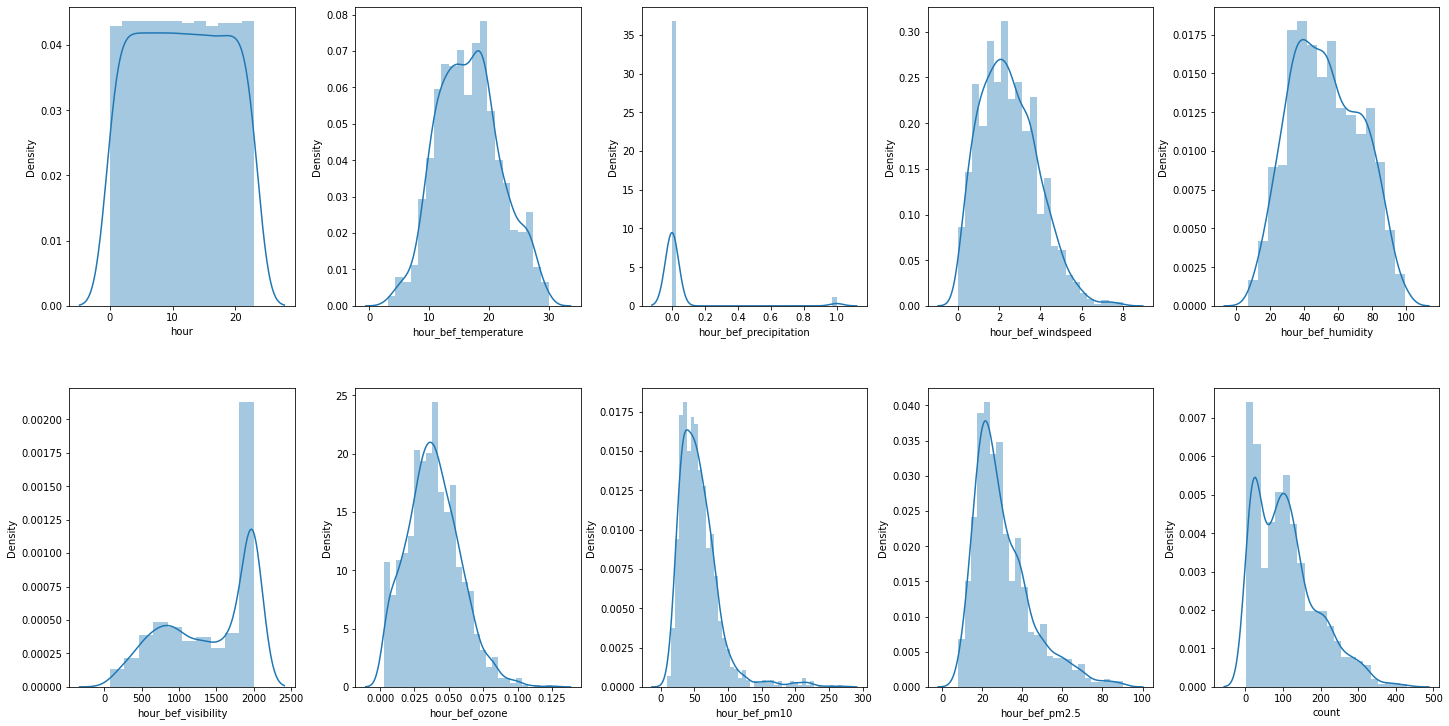

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df_null.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

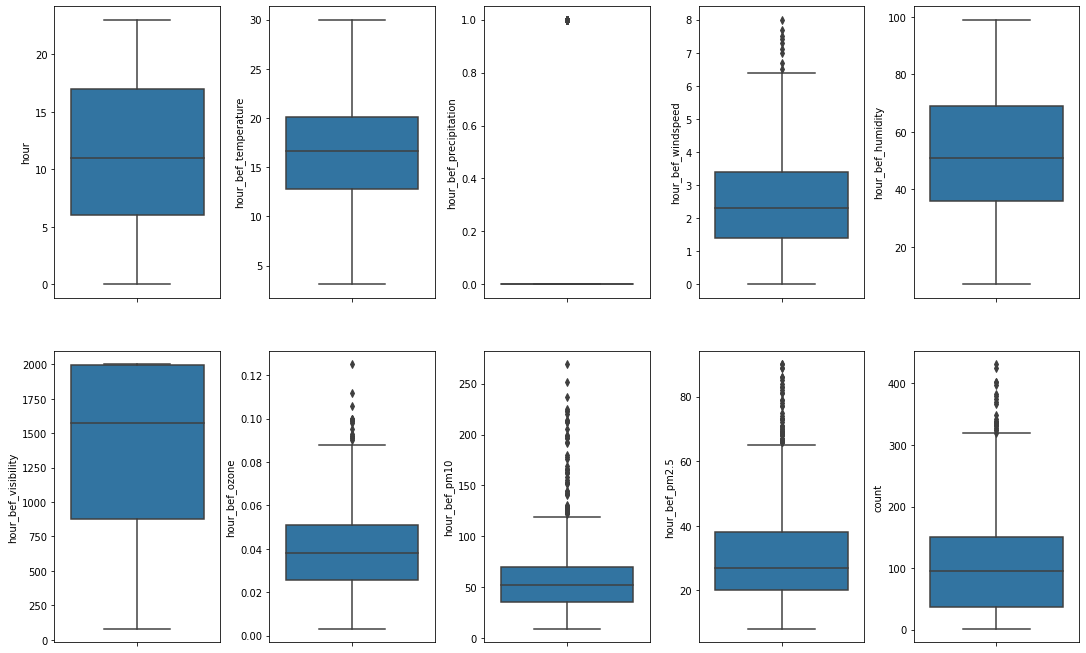

In [ ]:
# 이상치 확인
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15,9))
index = 0
axs = axs.flatten()
for k,v in df_null.items():
    sns.boxplot(y=k, data=df_null, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)